In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU device:',torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU avaialable, Using CPU')

torch.cuda.set_device(2)

GPU device: NVIDIA RTX A6000


In [2]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

set_seeds(42)

# Defining Uniform distribution per batch:
 - N = Number of samples per batch = batch size = 1024
 - C = Number of categories = 34
 - Perfectly Uniform Distribution per batch = N/C = 1024/34 = 30.12 ( We nwwd to round off this number because we cannot have fractional images.)
 - Allocate the Integer part to each category and distribute the remaining samples one by one to the categories.

In [3]:
import numpy as np

def create_uniform_distribution(batch_size, num_categories):
    ideal_fractional_count = batch_size / num_categories
    base_count = int(ideal_fractional_count)  # Integer part
    remainder = ideal_fractional_count - base_count  # Fractional part

    # Initialize distribution with the base count
    distribution = np.full(num_categories, base_count)

    # Calculate how many samples are left to distribute
    samples_left = batch_size - np.sum(distribution)

    # Distribute the remaining samples
    for _ in range(samples_left):
        min_index = np.argmin(distribution - (base_count + remainder))
        distribution[min_index] += 1

    return distribution

ideal_uniform = create_uniform_distribution(1024, 34)
print(ideal_uniform)
print("Total:", np.sum(ideal_uniform))  # Should be 1024

[31 31 31 31 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 30]
Total: 1024


# But our last batch contains only 793 images. 

- So for last batch we need to have a different Uniform distribution for the comparison. 

In [5]:
import numpy as np

def create_uniform_distribution(batch_size, num_categories):
    ideal_fractional_count = batch_size / num_categories
    base_count = int(ideal_fractional_count)  # Integer part
    remainder = ideal_fractional_count - base_count  # Fractional part

    # Initialize distribution with the base count
    distribution = np.full(num_categories, base_count)

    # Calculate how many samples are left to distribute
    samples_left = batch_size - np.sum(distribution)

    # Distribute the remaining samples
    for _ in range(samples_left):
        min_index = np.argmin(distribution - (base_count + remainder))
        distribution[min_index] += 1

    return distribution

# for standard batches
ideal_uniform_standard = create_uniform_distribution(1024, 34)

# for the last batch
ideal_uniform_last_batch = create_uniform_distribution(793, 34)
print(ideal_uniform_last_batch)
print("Total:", np.sum(ideal_uniform_last_batch))


[24 24 24 24 24 24 24 24 24 24 24 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23]
Total: 793


In [12]:
def create_uniform_distribution(batch_size, num_categories):
    ideal_fractional_count = batch_size / num_categories
    # Integer part
    base_count = int(ideal_fractional_count)
    # Fraction Part - Last batch should contain samples less than 1024 - Exact 793 Samples
    remainder = ideal_fractional_count - base_count
    # Initialize distribution with the base count
    distribution = np.full(num_categories, base_count)
    # Calculate how many samples are left to distribute
    samples_left = batch_size - np.sum(distribution)

    for _ in range(samples_left):
        min_index = np.argmin(distribution - (base_count + remainder))
        distribution[min_index] += 1

    # Normalize the distribution to make it a probability distribution
    normalized_uniform_distribution = distribution / np.sum(distribution)

    return normalized_uniform_distribution

# for the last batch
ideal_uniform_last_batch = create_uniform_distribution(793, 34)
print(ideal_uniform_last_batch)
print("Total:", np.sum(ideal_uniform_last_batch))

[0.03026482 0.03026482 0.03026482 0.03026482 0.03026482 0.03026482
 0.03026482 0.03026482 0.03026482 0.03026482 0.03026482 0.02900378
 0.02900378 0.02900378 0.02900378 0.02900378 0.02900378 0.02900378
 0.02900378 0.02900378 0.02900378 0.02900378 0.02900378 0.02900378
 0.02900378 0.02900378 0.02900378 0.02900378 0.02900378 0.02900378
 0.02900378 0.02900378 0.02900378 0.02900378]
Total: 1.0


# As the original dataset distribution based on class ratio plot and class count plot doesn't results in a bell shaped curve it means the data is not normally distributed.

# KL Divergence Calculation:
* The KL divergence from distribution Q to P is defined as:

$$ D_{\text{KL}}(P || Q) = \sum_{i} P(i) \log\left(\frac{P(i)}{Q(i)}\right) $$

Where $P(i)$ and  $Q(i)$ are the probabilities of the $ith$ event in distributions $P$ and $Q$, respectively.

* Ensure that there are no zero probabilities in your distributions when calculating the KL divergence. If necessary, apply smoothing (e.g., add a small constant to all probabilities).
* The KL divergence is not symmetric.
* A lower KL divergence value indicates a distribution that is closer to the uniform distribution.

# 1. Determine the KL divergence between the (Uniform Distribution per batch per category) & (Dataloader 1 distribution per batch per category)

# 2. Determine the KL divergence between the (Uniform Distribution per batch per category) & (Dataloader 2 distribution per batch per category)

In [6]:
from collections import Counter

cmp_sub_list = ['/System/img.png', '/System/img.png', 'Customer', 'The System', 'The System']
most_common_subject = Counter(cmp_sub_list).most_common(1)
most_common_subject

[('/System/img.png', 2)]

In [7]:
most_common_subject,count = Counter(cmp_sub_list).most_common(1)[0]
print(most_common_subject)
print(count)

/System/img.png
2


In [8]:
most_common_subject = Counter(cmp_sub_list).most_common(1)[0][0]
print(most_common_subject)
#print(count)

/System/img.png


In [13]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import cumfreq
import pickle
import pandas as pd
from scipy.stats import entropy
from collections import Counter

from a_custom_dataset import CustomImageDataset
from b_weightedimagedataset import WeightedImageDataset

from sklearn.metrics.pairwise import cosine_similarity
import hdbscan

CATEGORY_MAPPING = {
    'closing_bottle': 0, 'closing_door_inside': 1, 'closing_door_outside': 2, 'closing_laptop': 3,
    'drinking': 4, 'eating': 5, 'entering_car': 6, 'exiting_car': 7, 'fastening_seat_belt': 8,
    'fetching_an_object': 9, 'interacting_with_phone': 10, 'looking_or_moving_around (e.g. searching)': 11,
    'opening_backpack': 12, 'opening_bottle': 13, 'opening_door_inside': 14, 'opening_door_outside': 15,
    'opening_laptop': 16, 'placing_an_object': 17, 'preparing_food': 18, 'pressing_automation_button': 19,
    'putting_laptop_into_backpack': 20, 'putting_on_jacket': 21, 'putting_on_sunglasses': 22, 'reading_magazine': 23,
    'reading_newspaper': 24, 'sitting_still': 25, 'taking_laptop_from_backpack': 26, 'taking_off_jacket': 27,
    'taking_off_sunglasses': 28, 'talking_on_phone': 29, 'unfastening_seat_belt': 30, 'using_multimedia_display': 31,
    'working_on_laptop': 32, 'writing': 33
}

class DataLoaderComparisonKL:
    def __init__(self, feature_file_path, label_file_path, img_path_file_path, num_categories, batch_size):
        self.batch_size = batch_size
        self.num_categories = num_categories
        self.features, self.labels, self.img_paths = self.load_data(feature_file_path, label_file_path, img_path_file_path)
        self.dataloader_a, self.dataloader_b, self.weights_list, self.pred_labels_b, self.pred_cluster_counts, self.n_clusters_b_noise = self.initialize_dataloaders()

    def load_data(self, feature_file_path, label_file_path, img_path_file_path):
        with open(feature_file_path, 'rb') as file:
            features = pickle.load(file)
        with open(label_file_path, 'rb') as file:
            labels = pickle.load(file)
        with open(img_path_file_path, 'rb') as file:
            img_paths = pickle.load(file)
        return features, labels, img_paths

    def initialize_dataloaders(self):
        # CustomImageDataset and WeightedImageDataset initialization
        transform_a = transforms.Compose([
                transforms.Resize((224, 224)),  # Resize the image to a fixed size (224x224)
                transforms.ToTensor(),          # Convert the image to a PyTorch tensor
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],  # Normalize the image channels (mean)
                    std=[0.229, 0.224, 0.225]    # Normalize the image channels (std)
                )
            ])
        dataset_a = CustomImageDataset(root_dir='/net/polaris/storage/deeplearning/sur_data/rgb_daa/split_0/train', transform=transform_a)
        dataloader_a = DataLoader(dataset_a, batch_size=self.batch_size, shuffle=True, num_workers=10, drop_last=False)

        # Batch conversion of precomputed features, Batches = 254, Batch Size 1024, Feature size: [1,1280]
        features_loader = [self.features[i:i+1024] for i in range(0, len(self.features), 1024)]
        gt_labels_loader = [self.labels[i:i+1024] for i in range(0, len(self.labels), 1024)]

        # Get the weights
        weights_list, pred_labels_b, pred_cluster_counts, n_clusters_b_noise, n_noise = self.process_batches(features_loader)
        dataset_b = WeightedImageDataset(self.img_paths, weights_list, gt_labels_loader)
        sampler_b = WeightedRandomSampler(dataset_b.weights, num_samples=len(dataset_b.weights), replacement=True)
        dataloader_b = DataLoader(dataset_b, batch_size=self.batch_size, sampler=sampler_b, num_workers=10)

        return dataloader_a, dataloader_b, weights_list, pred_labels_b, pred_cluster_counts, n_clusters_b_noise

    def compute_weights_cosine_dist(self, features):
        cosine_dist_matrix = 1 - cosine_similarity(features).astype(np.float64)
        clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='precomputed', cluster_selection_method='eom')
        labels = clusterer.fit_predict(cosine_dist_matrix)

        weights = np.zeros_like(labels, dtype=float)
        unique_labels = np.unique(labels)
        noise_label = -1
        max_label = unique_labels.max()

        num_clusters_before_noise = len(unique_labels[unique_labels != noise_label])
        num_noise_points = len(labels[labels == noise_label])

        for label in unique_labels:
            indices = np.where(labels == label)[0]
            group_size = len(indices)

            if label == noise_label:
                for noise_index in indices:
                    max_label += 1
                    weights[noise_index] = 1
                    labels[noise_index] = max_label
            else:
                weights[indices] = 1.0 / group_size

        total_clusters = len(np.unique(labels))
        return weights, labels, total_clusters, num_clusters_before_noise, num_noise_points


    def process_batches(self, dataloader):
        all_weights = []
        all_labels = []
        all_cluster_counts = []
        n_clusters_b_noise = []
        n_noise = []

        for batch_features in dataloader:
            weights, labels, total_clusters, num_clusters_before_noise, num_noise_points = self.compute_weights_cosine_dist(batch_features)
            all_weights.append(weights)
            all_labels.append(labels)
            all_cluster_counts.append(total_clusters)
            n_clusters_b_noise.append(num_clusters_before_noise)
            n_noise.append(num_noise_points)

        return all_weights, all_labels, all_cluster_counts, n_clusters_b_noise, n_noise

    def track_category_counts_a(self, dataloader_a):
        # The shape of the array is defined by two dimensions: 
        # the number of batches in the DataLoader (len(dataloader_a)): 254 and 
        # the number of categories (self.num_categories) : 34.
        category_counts_a = np.zeros((len(dataloader_a), self.num_categories))

        for batch_idx, (_, targets) in enumerate(dataloader_a):
            for category in range(self.num_categories):
                category_counts_a[batch_idx, category] = torch.sum(targets == category).item()

        return category_counts_a
    
    def track_category_counts_b(self, dataloader_b):
        # Example Shape for a batch size of 1024 : [254,34]
        category_counts_b = np.zeros((len(dataloader_b), self.num_categories))

        for batch_idx, (_,_, targets,_) in enumerate(dataloader_b):
            for category in range(self.num_categories):
                category_counts_b[batch_idx, category] = torch.sum(targets == category).item()

        return category_counts_b
    
    ################### Uniform distribution for Comparison ####################

    def create_uniform_distribution(self, batch_size):
        ideal_fractional_count = batch_size / self.num_categories
        # Integer part
        base_count = int(ideal_fractional_count)
        # Fraction Part - Last batch should contain samples less than 1024 - Exact 793 Samples
        remainder = ideal_fractional_count - base_count
        # Initialize distribution with the base count
        distribution = np.full(self.num_categories, base_count)
        # Calculate how many samples are left to distribute
        samples_left = batch_size - np.sum(distribution)

        for _ in range(samples_left):
            min_index = np.argmin(distribution - (base_count + remainder))
            distribution[min_index] += 1

        # Normalize the distribution to make it a probability distribution
        normalized_uniform_distribution = distribution / np.sum(distribution)

        return normalized_uniform_distribution
    
    #################### KL Divergence Calculation #########################

    def kl_divergence(self, p, q):
        return entropy(p, q)

    def calculate_kl_divergences(self, counts, batch_sizes):
        kl_divergences = []
        for i, batch_count in enumerate(counts):
            uniform_dist = self.create_uniform_distribution(batch_sizes[i])
            normalized_count = batch_count / np.sum(batch_count)
            kl_div = self.kl_divergence(normalized_count, uniform_dist)
            kl_divergences.append(kl_div)

        return np.array(kl_divergences)
    
    ################# Counting for Visualisation ##########################
        
    #  Our Goal is to track the uniqueness of each image (i.e., each instance) 
    #  rather than just the class variety, using the image path is a much more 
    #  appropriate choice to track the count of unique images.
    def track_images_and_most_picked_samples(self, dataloader):
        unique_images_seen = set()
        unique_images_seen_per_batch = []
        most_picked_per_batch = []
        overall_counter = Counter()

        for _, _, _, paths in dataloader:
            # Track unique images
            unique_images_seen.update(paths)
            unique_images_seen_per_batch.append(len(unique_images_seen))

            # Track most picked samples per batch
            if len(paths) > 0:
                batch_counter = Counter(paths)
                most_common, count = batch_counter.most_common(1)[0]
                most_picked_per_batch.append((most_common, count))
            else:
                most_picked_per_batch.append((None, 0))

            # Update overall counter for most picked sample overall
            overall_counter.update(paths)

        # Determine the most picked sample overall
        most_common_overall, most_common_count_overall = overall_counter.most_common(1)[0]

        # Total unique samples seen
        total_unique_samples_seen = len(unique_images_seen)

        return unique_images_seen_per_batch, total_unique_samples_seen, most_picked_per_batch, (most_common_overall, most_common_count_overall)

    ################### Save the Results ######################################

    def save_results_to_pickle(self, data, file_name):
        with open(file_name, 'wb') as file:
            pickle.dump(data, file)
    
    #################### Visualisation Functions Here #########################
    
    def plot_kl_divergences(self, kl_divergences_a, kl_divergences_b):
        plt.figure(figsize=(12, 6))
        plt.plot(kl_divergences_a, label='DataLoader1')
        plt.plot(kl_divergences_b, label='DataLoader2')
        plt.xlabel('Batch Number')
        plt.ylabel('KL Divergence')
        plt.title('KL Divergence Comparison Between Two DataLoaders')
        plt.legend()
        plt.show()

    def plot_probability_distribution(self, category_counts, category_index, batch_indices):
        for batch_idx in batch_indices:
            sns.histplot(category_counts[batch_idx, category_index], kde=True, stat="density")
        
        plt.title(f"Probability Distribution for Category {category_index}")
        plt.xlabel("Sample Count")
        plt.ylabel("Density")
        plt.show()

    def plot_cdf(self, category_counts, category_index, batch_indices):
        for batch_idx in batch_indices:
            data = category_counts[batch_idx, category_index]
            a, b = np.histogram(data, bins=100, density=True)
            cdf = np.cumsum(a) * np.diff(b[:2])

            plt.plot(b[1:], cdf, label=f'Batch {batch_idx}')
        
        plt.title(f"Cumulative Distribution Function (CDF) for Category {category_index}")
        plt.xlabel("Sample Count")
        plt.ylabel("CDF")
        plt.legend()
        plt.show()

    def plot_category_frequency_heatmap(self, category_counts):
        plt.figure(figsize=(12, 8))
        sns.heatmap(category_counts, annot=True, fmt="d", cmap="YlGnBu")
        plt.title("Category Frequency per Batch")
        plt.xlabel("Category")
        plt.ylabel("Batch")
        plt.show()

    def plot_most_picked_samples_bar(self, most_picked_per_batch):
        sample_counts = Counter(most_picked_per_batch)
        samples, counts = zip(*sample_counts.items())

        plt.figure(figsize=(12, 6))
        plt.bar(samples, counts)
        plt.title("Frequency of Most Picked Samples")
        plt.xlabel("Sample")
        plt.ylabel("Frequency")
        plt.xticks(rotation=90)  # Rotate labels for better readability
        plt.show()

    def plot_unique_samples_scatter(self, unique_samples_seen_per_batch):
        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(unique_samples_seen_per_batch)), unique_samples_seen_per_batch)
        plt.title("Cumulative Unique Samples Seen per Batch")
        plt.xlabel("Batch")
        plt.ylabel("Cumulative Unique Samples")
        plt.show()

    def plot_category_counts_boxplot(self, category_counts):
        plt.figure(figsize=(12, 8))
        sns.boxplot(data=category_counts)
        plt.title("Box Plot of Category Counts per Batch")
        plt.xlabel("Category")
        plt.ylabel("Counts")
        plt.show()

    def compare_dataloaders_and_save(self, save_path):
        counts_a = self.track_category_counts_a(self.dataloader_a)
        counts_b = self.track_category_counts_b(self.dataloader_b)

        batch_sizes = [1024] * (len(counts_a) - 1) + [793]  # Update as per your batch sizes
        kl_divergences_a = self.calculate_kl_divergences(counts_a, batch_sizes)
        kl_divergences_b = self.calculate_kl_divergences(counts_b, batch_sizes)
        b_unique_images_per_batch, b_total_unique_samples, b_most_picked_per_batch, tuple_most_common_sample = self.track_images_and_most_picked_samples(self.dataloader_b)

        # Save the results
        self.save_results_to_pickle(counts_a, f'{save_path}/counts_a.pkl')
        self.save_results_to_pickle(counts_b, f'{save_path}/counts_b.pkl')
        self.save_results_to_pickle(kl_divergences_a, f'{save_path}/kl_divergences_a.pkl')
        self.save_results_to_pickle(kl_divergences_b, f'{save_path}/kl_divergences_b.pkl')
        self.save_results_to_pickle(b_unique_images_per_batch, f'{save_path}/b_unique_images_per_batch.pkl')
        self.save_results_to_pickle(b_total_unique_samples, f'{save_path}/b_total_unique_samples.pkl')
        self.save_results_to_pickle(b_most_picked_per_batch, f'{save_path}/b_most_picked_per_batch.pkl')
        self.save_results_to_pickle(tuple_most_common_sample, f'{save_path}/tuple_most_common_sample.pkl')

        return counts_a, counts_b, kl_divergences_a, kl_divergences_b, b_unique_images_per_batch, b_total_unique_samples, b_most_picked_per_batch, tuple_most_common_sample

In [14]:
# Define file paths and parameters
feature_file_path = '/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/clustering_notebooks/split_0/all_clustering_features.pkl'
label_file_path = '/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/clustering_notebooks/split_0/all_clustering_labels.pkl'
img_path_file_path = '/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/clustering_notebooks/split_0/all_clustering_imagepaths.pkl'
num_categories = 34
batch_size = 1024
save_path = '/home/sur06423/thesis/dino_v2/dinov2_experiments/dataset_creation/01_final_dataloader_experiments/KL_results'

# Create an instance of DataLoaderComparisonKL and perform the comparison
comparison_kl = DataLoaderComparisonKL(feature_file_path, label_file_path, img_path_file_path, num_categories, batch_size)
counts_a, counts_b, kl_divergences_a, kl_divergences_b, b_unique_images_per_batch, b_total_unique_samples, b_most_picked_per_batch, tuple_most_common_sample = comparison_kl.compare_dataloaders_and_save(save_path)


# Analysis of KL Divergence Plot:

- General Trend: Both lines on the plot represent the KL divergence for each batch. DataLoader1 is depicted in blue and DataLoader2 in orange. The vertical axis represents the KL divergence values, and the horizontal axis corresponds to the batch numbers.

- DataLoader1 (Blue Line): The KL divergence values for DataLoader1 fluctuate around 0.9 and above, indicating a greater divergence from the uniform distribution compared to DataLoader2. This suggests that the category distribution in each batch for DataLoader1 is less uniform, with certain categories possibly being over- or under-represented.

- DataLoader2 (Orange Line): The KL divergence values for DataLoader2 are generally lower, fluctuating around 0.65 to 0.75. This suggests that the sample distribution in DataLoader2 is closer to the uniform distribution, indicating a more balanced representation of categories within each batch.

# Final Interpretation:

- Balanced Sampling: DataLoader2 appears to have a more balanced sampling approach, leading to batches that are more uniformly distributed across categories when compared to DataLoader1. This is due to the use of a weighted sampling strategy that aims to equalize the representation of categories across batches.

- Consistency: The consistency of DataLoader2 in maintaining lower KL divergence values across batches suggests a stable and predictable sampling behavior. In contrast, DataLoader1 shows more variability, which could lead to less stable training behavior if used in a machine learning/ deep learning context.

- Suitability for Machine/Deep Learning: The goal is to have a balanced and unbiased representation of categories in each batch, DataLoader2 might be more suitable for training machine/deep learning models, as it could help prevent the models from overfitting to over-represented categories.

- Potential Overfitting: The higher KL divergence in DataLoader1 may result in models trained with this data being less generalizable due to potential overfitting to the categories that are disproportionately represented.

# Conclusion:

* We're aiming for a balanced and uniform representation of categories in our training batches, DataLoader2 seems to be the better choice based on the KL divergence plot.

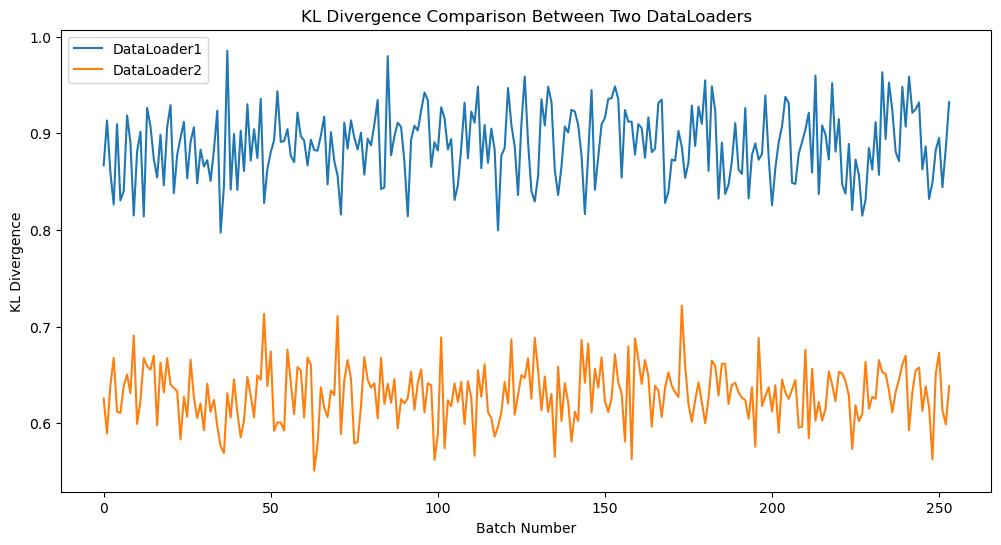

In [15]:
# KL Divergence Comparison Plots
comparison_kl.plot_kl_divergences(kl_divergences_a, kl_divergences_b)

ValueError: Unknown format code 'd' for object of type 'float'

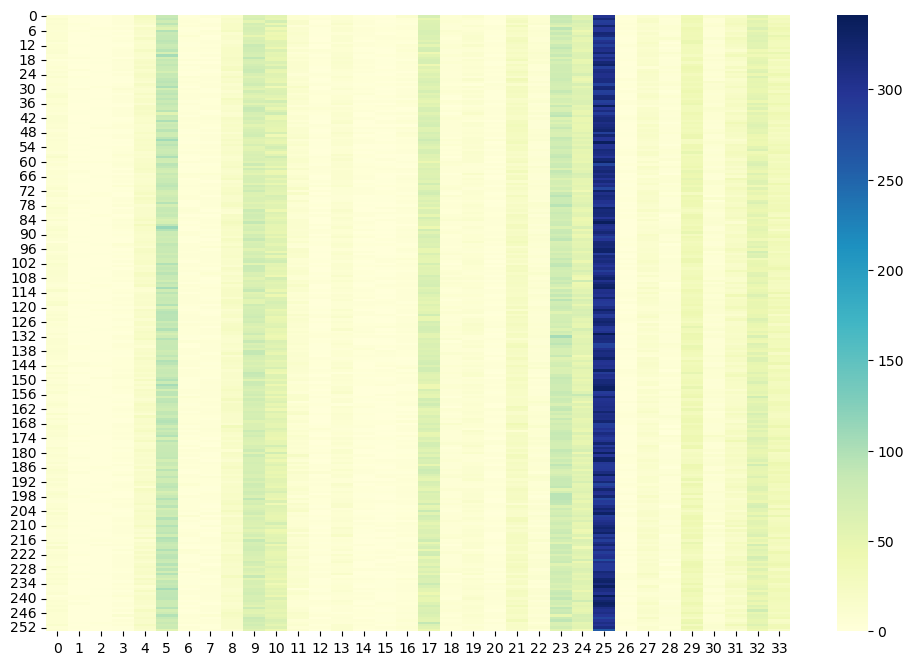

In [16]:
# Dataloader 1 Category Frequency Heatmap
comparison_kl.plot_category_frequency_heatmap(counts_a)

ValueError: Unknown format code 'd' for object of type 'float'

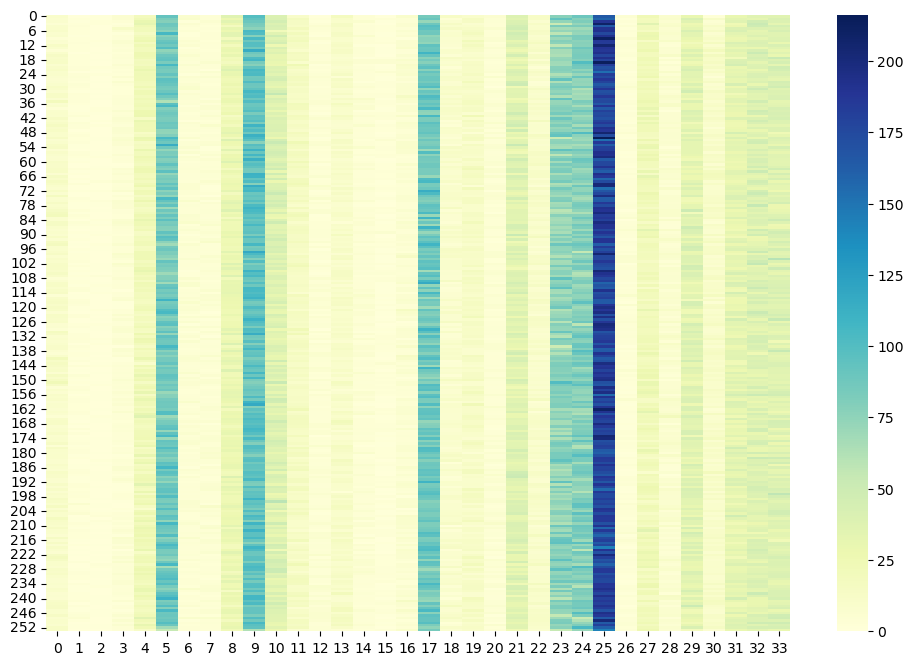

In [17]:
# Dataloader 1 Category Frequency Heatmap
comparison_kl.plot_category_frequency_heatmap(counts_b)

In [21]:
sample_counts = Counter(b_most_picked_per_batch)
sample_counts
samples, counts = zip(*sample_counts.items())
samples, counts

((('/net/polaris/storage/deeplearning/sur_data/rgb_daa/split_0/train/reading_newspaper/12_vp12_run1_2018-05-24-15-44-28.kinect_color_frames_16572_16617_ann_80_chunk_0/img_016593.png',
   2),
  ('/net/polaris/storage/deeplearning/sur_data/rgb_daa/split_0/train/fetching_an_object/8_vp8_run1d_2018-05-23-14-54-38.kinect_color_frames_7884_7921_ann_22_chunk_0/img_007884.png',
   2),
  ('/net/polaris/storage/deeplearning/sur_data/rgb_daa/split_0/train/reading_newspaper/2_vp2_run2_2018-05-24-17-22-26.kinect_color_frames_4891_4937_ann_10_chunk_14/img_004923.png',
   2),
  ('/net/polaris/storage/deeplearning/sur_data/rgb_daa/split_0/train/putting_on_jacket/8_vp8_run1d_2018-05-23-14-54-38.kinect_color_frames_13886_13932_ann_50_chunk_9/img_013918.png',
   2),
  ('/net/polaris/storage/deeplearning/sur_data/rgb_daa/split_0/train/sitting_still/1_vp1_run2_2018-05-29-14-33-44.kinect_color_frames_6164_6209_ann_15_chunk_28/img_006196.png',
   2),
  ('/net/polaris/storage/deeplearning/sur_data/rgb_daa/spl

# plot_unique_samples_scatter function

- The plot_unique_samples_scatter function creates a scatter plot to visualize the "cumulative unique samples seen per batch" in a DataLoader. Let's break down what this means:

- Cumulative Unique Samples: This refers to the total number of distinct samples encountered up to a certain point in the DataLoader. As we iterate through each batch, we keep adding any new, unique samples to a running total. This count includes all unique samples seen from the start up to and including the current batch.

- Per Batch: The count is updated for each batch. So, for each batch in the DataLoader, you calculate how many unique samples have been seen so far (including the samples in the current batch).

# Visualization in Scatter Plot:

- The x-axis of the plot represents each batch in the DataLoader. If there are N batches, you will have points plotted at positions 0, 1, 2, ..., N-1. => Total 254 batches from 0 to 253.
- The y-axis shows the cumulative number of unique samples seen up to each batch.
- Each point on the scatter plot represents the total number of unique samples that have been encountered by the time that batch has been processed.

- Example: Suppose you have a DataLoader with 5 batches, and the number of unique samples seen after processing each batch is as follows:

After Batch 1: 100 unique samples seen.
After Batch 2: 150 unique samples seen (50 new ones in Batch 2).
After Batch 3: 200 unique samples seen (50 new ones in Batch 3).
After Batch 4: 220 unique samples seen (20 new ones in Batch 4).
After Batch 5: 250 unique samples seen (30 new ones in Batch 5).
- The scatter plot will have points at (1, 100), (2, 150), (3, 200), (4, 220), and (5, 250).

* Purpose: This visualization helps to understand how quickly new, unique samples are being introduced as we process each batch. It's particularly useful in scenarios where we're dealing with data sampling that might include repetition of samples, such as when using a WeightedRandomSampler. It shows whether the DataLoader is continually introducing new samples or if it starts to mostly repeat samples after a certain point.

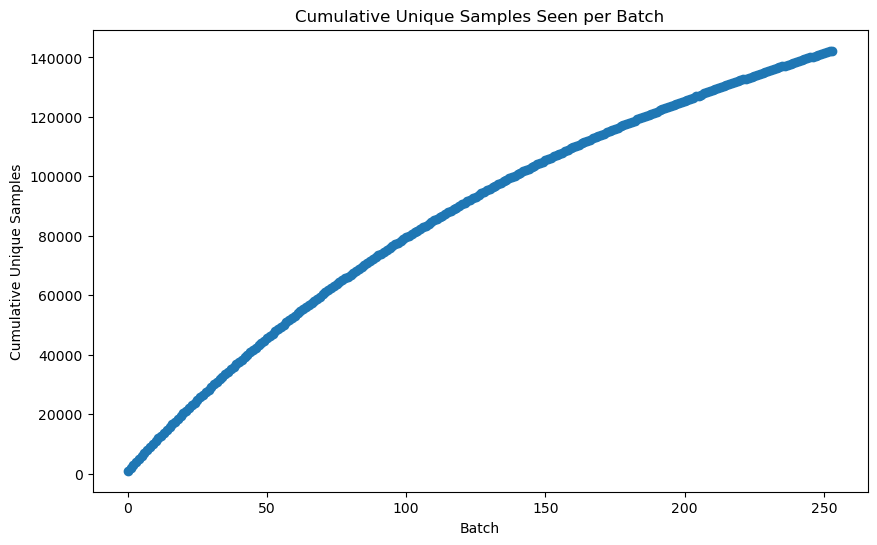

In [22]:
# Most images picked per batch
comparison_kl.plot_unique_samples_scatter(b_unique_images_per_batch)

# plot_category_counts_boxplot function
* The plot_category_counts_boxplot function generates a box plot to visualize the distribution of category counts per batch in our data. Let's dissect what this means:

* Box Plot: A box plot is a standardized way of displaying the distribution of data based on a five-number summary: minimum, first quartile (Q1), median, third quartile (Q3), and maximum. It can also show outliers.

* Category Counts: This refers to the number of times each category appears in each batch. If your dataset has multiple categories (like different types of activities or classes, here in our case there are 34 categories), this count represents how many samples of each category are present in a given batch.

* Per Batch: The box plot is created for each category across all batches. This means you'll have a separate box for each category, showing the distribution of its counts across different batches.

# Visualization in Box Plot:

* The x-axis of the box plot represents different categories. If you have N categories, there will be N boxes along the x-axis. Here N =34.
* The y-axis shows the counts of each category. Each box represents the distribution of counts for a particular category across all batches.

* The box itself shows the interquartile range (IQR - the range between the first and third quartiles). The line in the middle of the box is the median. The "whiskers" extend to show the range of the data, and points outside the whiskers are often considered as outliers.

* Example: Suppose you have a dataset with 3 categories (A, B, and C) and 5 batches. You count how many times each category appears in each batch. The box plot will then have three boxes, one for each category, showing how the counts of each category vary across the 5 batches.

* Purpose: This visualization is helpful to understand the distribution, variability, and central tendencies of the counts of each category across batches. It is particularly useful in identifying categories with high variability across batches and in spotting any outliers in category counts.

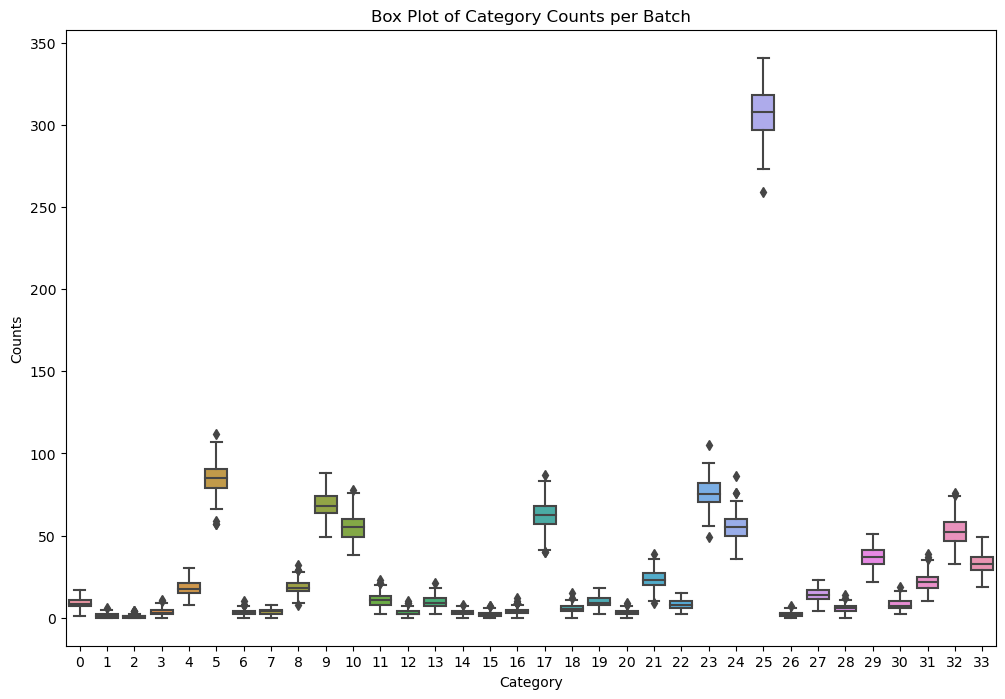

In [23]:
# Category Count Box Plot Count_a -> Dataloader 1
comparison_kl.plot_category_counts_boxplot(counts_a)

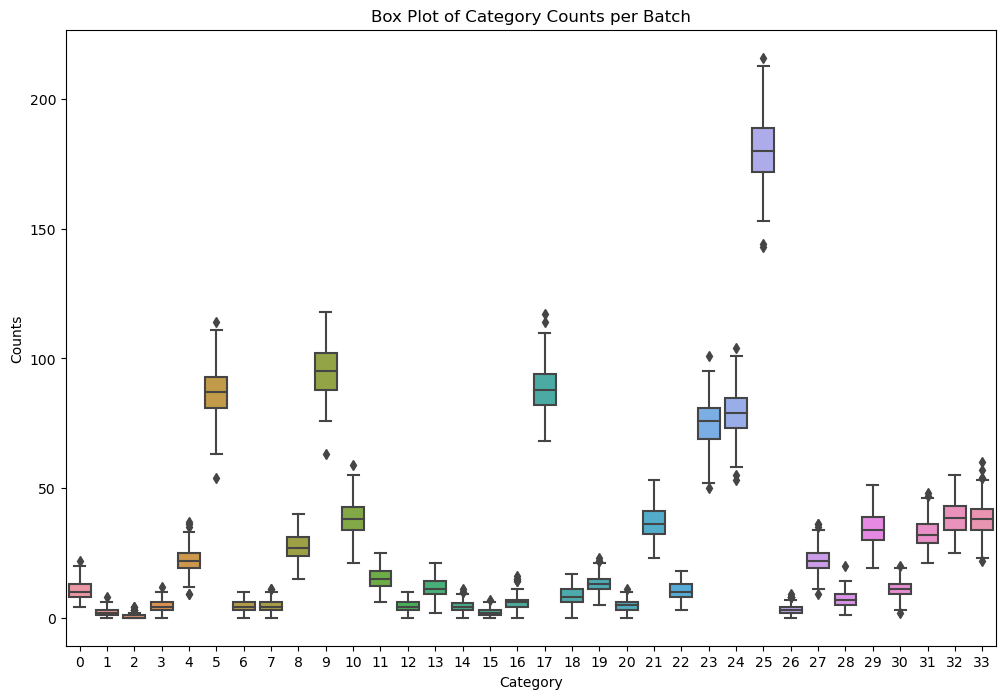

In [24]:
# Category Count Box Plot Count_a -> Dataloader 1
comparison_kl.plot_category_counts_boxplot(counts_b)

CATEGORY_MAPPING = {
    'closing_bottle': 0, 'closing_door_inside': 1, 'closing_door_outside': 2, 'closing_laptop': 3,
    'drinking': 4, 'eating': 5, 'entering_car': 6, 'exiting_car': 7, 'fastening_seat_belt': 8,
    'fetching_an_object': 9, 'interacting_with_phone': 10, 'looking_or_moving_around (e.g. searching)': 11,
    'opening_backpack': 12, 'opening_bottle': 13, 'opening_door_inside': 14, 'opening_door_outside': 15,
    'opening_laptop': 16, 'placing_an_object': 17, 'preparing_food': 18, 'pressing_automation_button': 19,
    'putting_laptop_into_backpack': 20, 'putting_on_jacket': 21, 'putting_on_sunglasses': 22, 'reading_magazine': 23,
    'reading_newspaper': 24, 'sitting_still': 25, 'taking_laptop_from_backpack': 26, 'taking_off_jacket': 27,
    'taking_off_sunglasses': 28, 'talking_on_phone': 29, 'unfastening_seat_belt': 30, 'using_multimedia_display': 31,
    'working_on_laptop': 32, 'writing': 33
}

# plot_cdf function
- The plot_cdf function is designed to visualize the Cumulative Distribution Function (CDF) for a specific category in selected batches of our data. Let's break down what this function is doing and what it means:

- Cumulative Distribution Function (CDF): The CDF is a function that describes the probability that a random variable takes on a value less than or equal to a certain threshold. Essentially, it shows the cumulative probability for each data point. 

# In the context of our data, the CDF indicates the proportion of samples in a category that fall below a certain count.

# Category Counts: 
- This refers to the number of occurrences of a specific category within each batch. category_counts is expected to be a 2D array where each row corresponds to a batch and each column to a category.

# Per Batch Visualization: 
- The function iterates over specified batch indices (batch_indices) and plots the CDF for a specified category (category_index) in each of those batches.

# Visualization in CDF Plot:

- The function first creates a histogram (np.histogram) of the counts of the specified category in a batch. The histogram is normalized (density=True) to represent probabilities.
- It then calculates the cumulative sum (np.cumsum) of these histogram values, which is the CDF. The CDF value at each bin edge indicates the probability that the category count is less than or equal to that bin edge.
- The plot (plt.plot) visualizes how this cumulative probability changes across different count values for the category.
- Each selected batch is plotted separately on the same graph, allowing for comparison between batches.
Purpose and Interpretation:

- The CDF plot helps understand the distribution of counts for a particular category across different batches.

- For example, if the CDF rises quickly to 1, it indicates that most of the counts are concentrated at lower values. A more gradual increase suggests a more even spread of counts.
Comparing CDFs across batches can reveal differences in the distribution of category counts between batches.

- In summary, this function provides a graphical representation of the cumulative probability of category counts per batch, offering insights into the distribution and variance of category occurrences within each batch.

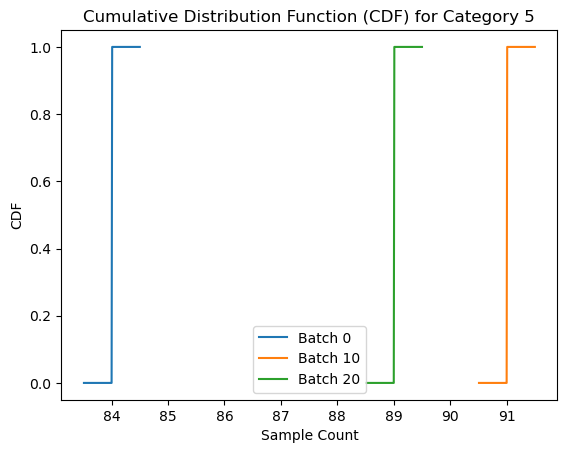

In [31]:
category_index = 5  # Eating Activity
batch_indices = [0, 10, 20]  # batch indices to visualize -> Batch numbe 0,10,20
#comparison_kl.plot_probability_distribution(counts_a, category_index, batch_indices)
comparison_kl.plot_cdf(counts_a, category_index, batch_indices)

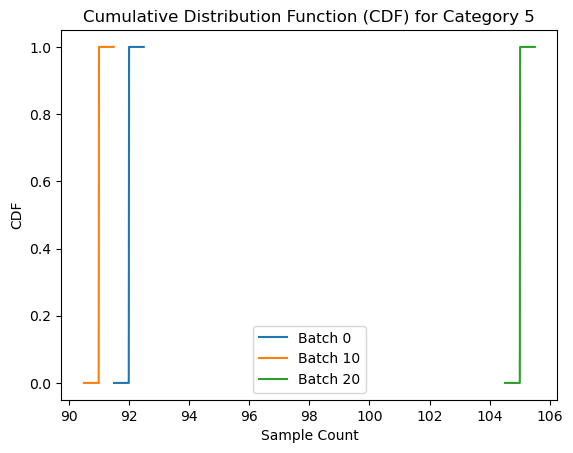

In [32]:
category_index = 5  # Eating Activity
batch_indices = [0, 10, 20]  # batch indices to visualize -> Batch numbe 0,10,20
#comparison_kl.plot_probability_distribution(counts_a, category_index, batch_indices)
comparison_kl.plot_cdf(counts_b, category_index, batch_indices)

# CDF for dataloader_a - Sitting_still
- The plot for dataloader_a shows three vertical lines, each representing the CDF of Category 25 in Batches 0, 10, and 20.
- Each line jumps from 0 to 1 very quickly, which indicates that the sample counts for Category 25 are very concentrated around a specific value within each batch.
- There's no gradual increase, which suggests that there is little to no variability in the number of samples of Category 25 across these batches – every batch has a similar count.
- The x-axis range from 300 to 325 shows that Category 25 has a high sample count across the batches.

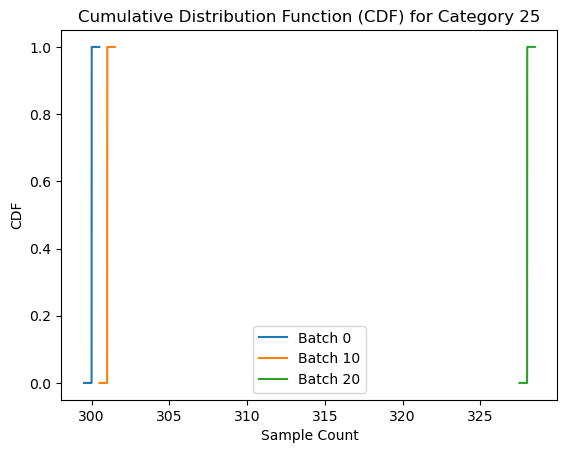

In [33]:
category_index = 25  # Eating Activity
batch_indices = [0, 10, 20]  # batch indices to visualize -> Batch numbe 0,10,20
#comparison_kl.plot_probability_distribution(counts_a, category_index, batch_indices)
comparison_kl.plot_cdf(counts_a, category_index, batch_indices)

# CDF for dataloader_b (Sitting_still):

- The CDF for dataloader_b similarly shows vertical lines, which implies that the counts for Category 25 are also concentrated around specific values.

- As with dataloader_a, the lines jump directly from 0 to 1, indicating low variability in count within each batch.

- The x-axis range from 165 to 185 in dataloader_b indicates that the counts for Category 25 are significantly lower compared to dataloader_a.

- The significant difference in counts between dataloader_a and dataloader_b indicate that the two DataLoaders have different sampling or weighting strategies, with dataloader_a having more instances of Category 25 per batch & dataloader_b being more balanced or having a different sampling strategy that results in fewer instances of Category 25.

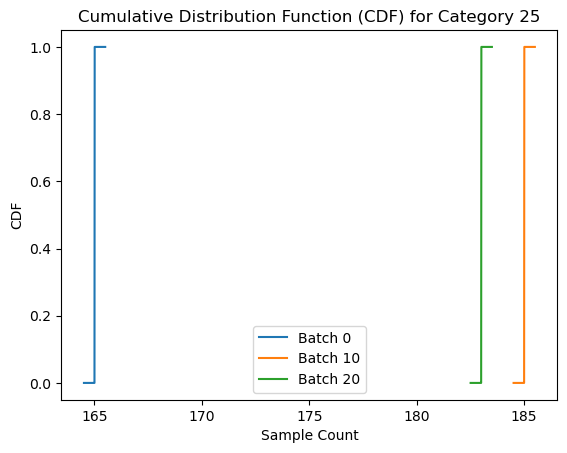

In [34]:
category_index = 25  # Eating Activity
batch_indices = [0, 10, 20]  # batch indices to visualize -> Batch numbe 0,10,20
#comparison_kl.plot_probability_distribution(counts_a, category_index, batch_indices)
comparison_kl.plot_cdf(counts_b, category_index, batch_indices)

In [30]:
counts_a[0,5]

84.0

# PDF function

-  In the context of the function plot_probability_distribution, the terms "density" and "Probability Density Function (PDF)" refer to the normalized count of occurrences within each bin of the histogram. 
- It allows the area under the histogram to integrate to 1, making it a probability distribution. This normalization is useful when comparing distributions that may have a different number of observations.

- category_counts: This is a 2D array where each row represents a batch, and each column represents a category. The values are the counts of occurrences of each category within each batch.

- category_index: This is the index for the specific category we want to visualize.

- batch_indices: This is a list of batch indices from which we want to collect category count data to visualize.

- Density Calculation: When sns.histplot is called with stat="density", it converts the histogram into a density plot where: The y-axis represents the density rather than the raw count. The area under the histogram sums to 1 (if you integrate over the entire range of the x-axis).

- KDE: The kde=True parameter tells sns.histplot to also plot a Kernel Density Estimate (KDE) on top of the histogram. A KDE is a smooth, continuous curve that estimates the probability density function of a random variable. It gives a sense of the "shape" of the distribution.

# Visualization: 
- The function plots a histogram for the specified category across the selected batches, normalized as a density plot. The KDE overlays this histogram to provide a smooth representation of the distribution.

* So, the meaning of "density" in this function is that it allows us to interpret the y-axis values as probabilities, so we can say things like "there's a 20% chance that the count falls within this particular bin" rather than "there are 20 occurrences in this bin". The "PDF" is represented by the KDE, which provides a smooth approximation of the histogram if you were to look at it as a continuous curve.

/home/sur06423/miniconda3/envs/dinov2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


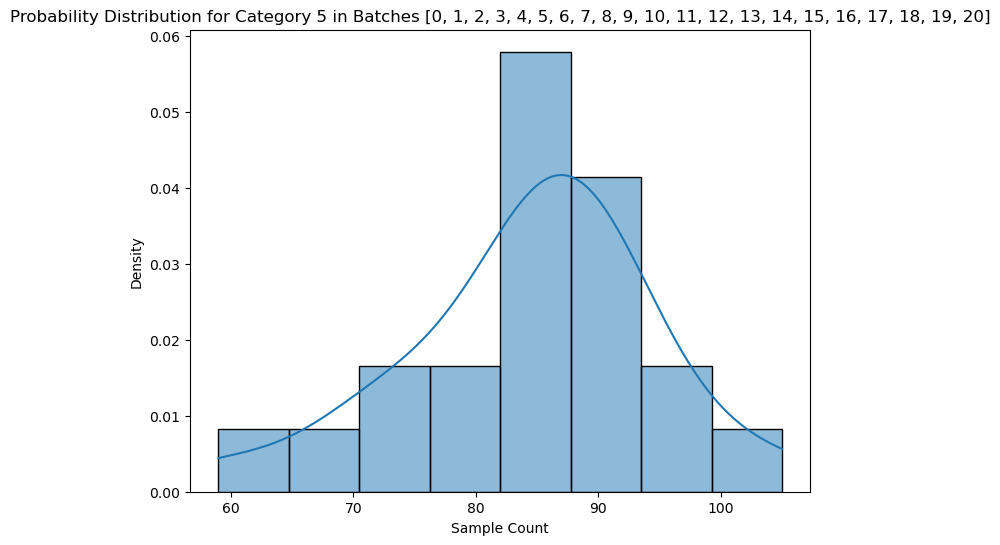

In [35]:
def plot_probability_distribution(category_counts, category_index, batch_indices):
        # Collect counts of the specified category from the specified batches
        category_data = [category_counts[batch_idx, category_index] for batch_idx in batch_indices]

        # Plot histogram
        plt.figure(figsize=(8, 6))
        sns.histplot(category_data, kde=True, stat="density")
        plt.title(f"Probability Distribution for Category {category_index} in Batches {batch_indices}")
        plt.xlabel("Sample Count")
        plt.ylabel("Density")
        plt.show()

category_index = 5  # Eating Activity
batch_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]  # batch indices to visualize -> Batch numbe 0,10,20
plot_probability_distribution(counts_a, category_index, batch_indices)

/home/sur06423/miniconda3/envs/dinov2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


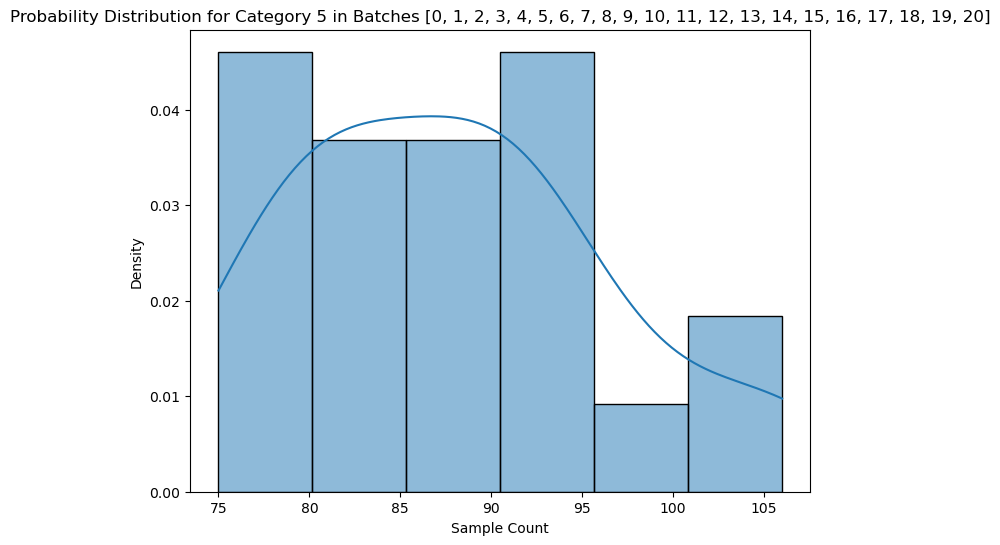

In [36]:
category_index = 5  # Eating Activity
batch_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]  # batch indices to visualize -> Batch numbe 0,10,20
plot_probability_distribution(counts_b, category_index, batch_indices)

/home/sur06423/miniconda3/envs/dinov2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


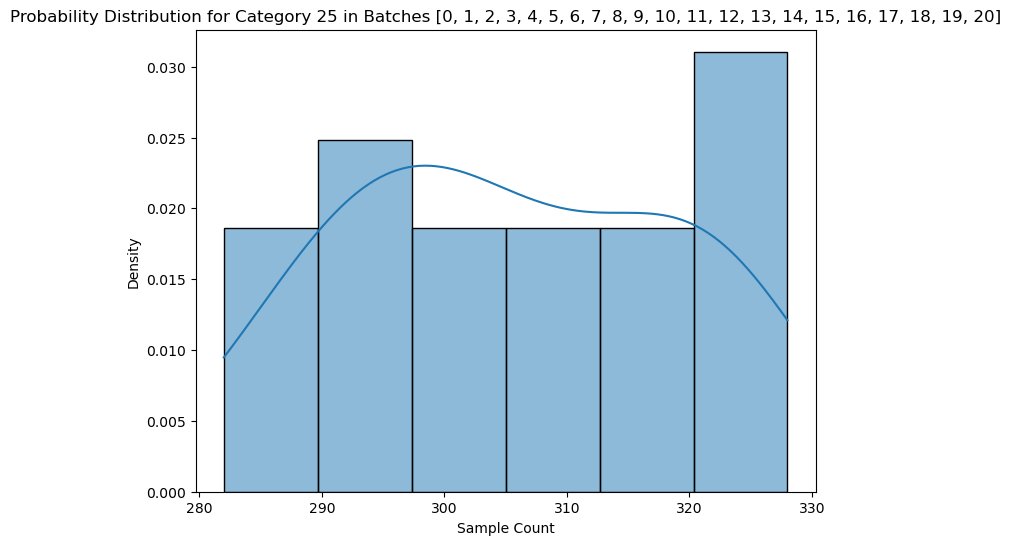

In [37]:
category_index = 25  # Eating Activity
batch_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]  # batch indices to visualize -> Batch numbe 0,10,20
plot_probability_distribution(counts_a, category_index, batch_indices)

/home/sur06423/miniconda3/envs/dinov2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


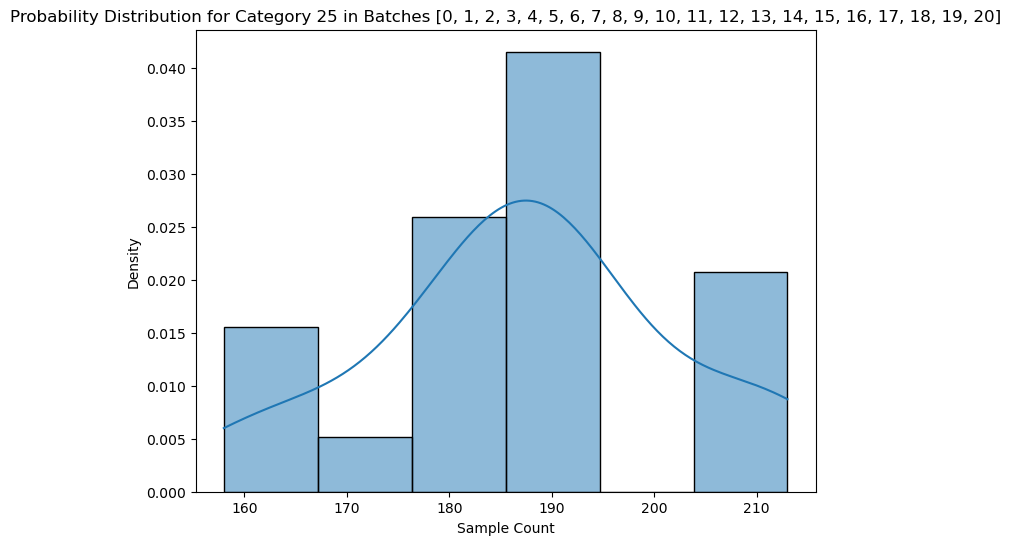

In [38]:
category_index = 25  # Eating Activity
batch_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]  # batch indices to visualize -> Batch numbe 0,10,20
plot_probability_distribution(counts_b, category_index, batch_indices)

# Analysis of PDF for dataloader_a:

- The histogram and KDE for dataloader_a indicate that most batches have a sample count for Category 25 clustered around 310.

- The distribution appears to be somewhat symmetrical around this mode, with a slight skew toward higher sample counts.

- The PDF suggests that Category 25 has a fairly consistent presence across the batches with a narrow range of variability in count, as indicated by the narrowness of the distribution.

/home/sur06423/miniconda3/envs/dinov2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


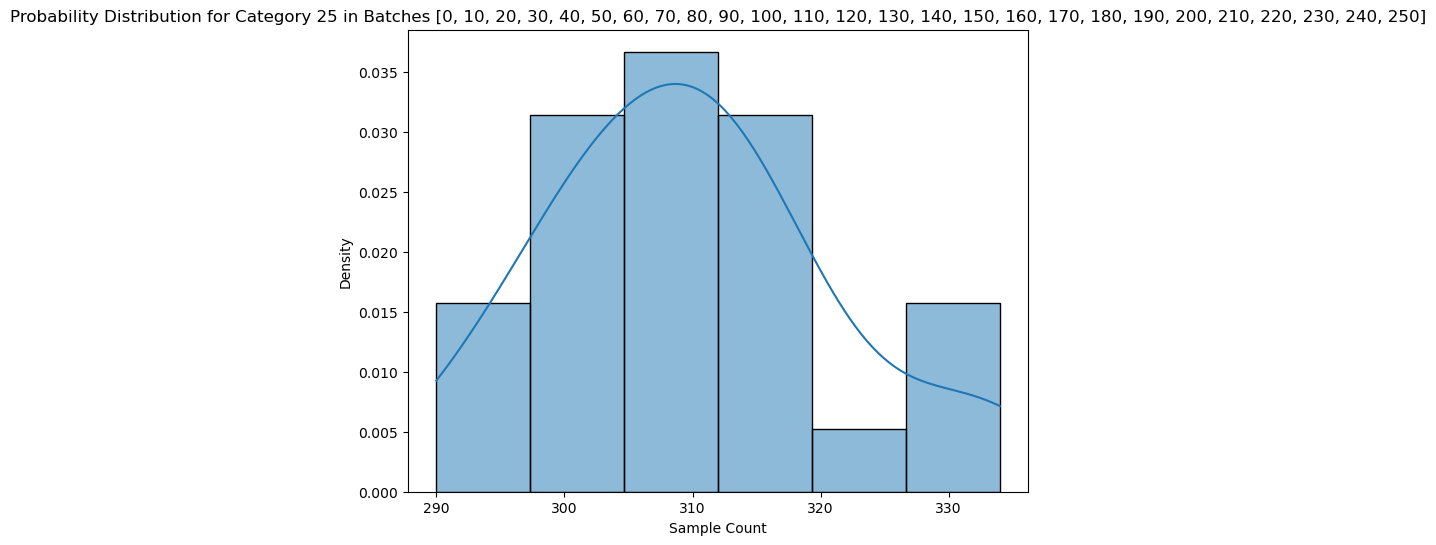

In [39]:
category_index = 25  # Eating Activity
batch_indices = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]  # batch indices to visualize -> Batch numbe 0,10,20
plot_probability_distribution(counts_a, category_index, batch_indices)

# Analysis of PDF for dataloader_b:

- For dataloader_b, the histogram and KDE show that the sample count for Category 25 varies more widely, with the most common counts appearing around 180 to 190.

- The distribution shows a wider spread of sample counts compared to dataloader_a, indicating more variability in how often Category 25 appears in each batch.

- The tails of the KDE, especially towards the right, suggest that there are batches with significantly higher counts, but these are less frequent.

- Dataloader_b displays greater variability in the counts of Category 25 across batches, suggesting that the frequency of this category is less uniform from batch to batch. 

- This is due to a more balanced sampling strategy, & downsampling of this category.

- The broader range of sample counts in dataloader_b might be an indicator of a deliberate strategy to prevent overfitting to this category by ensuring a more diverse exposure to different categories within each batch.

/home/sur06423/miniconda3/envs/dinov2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


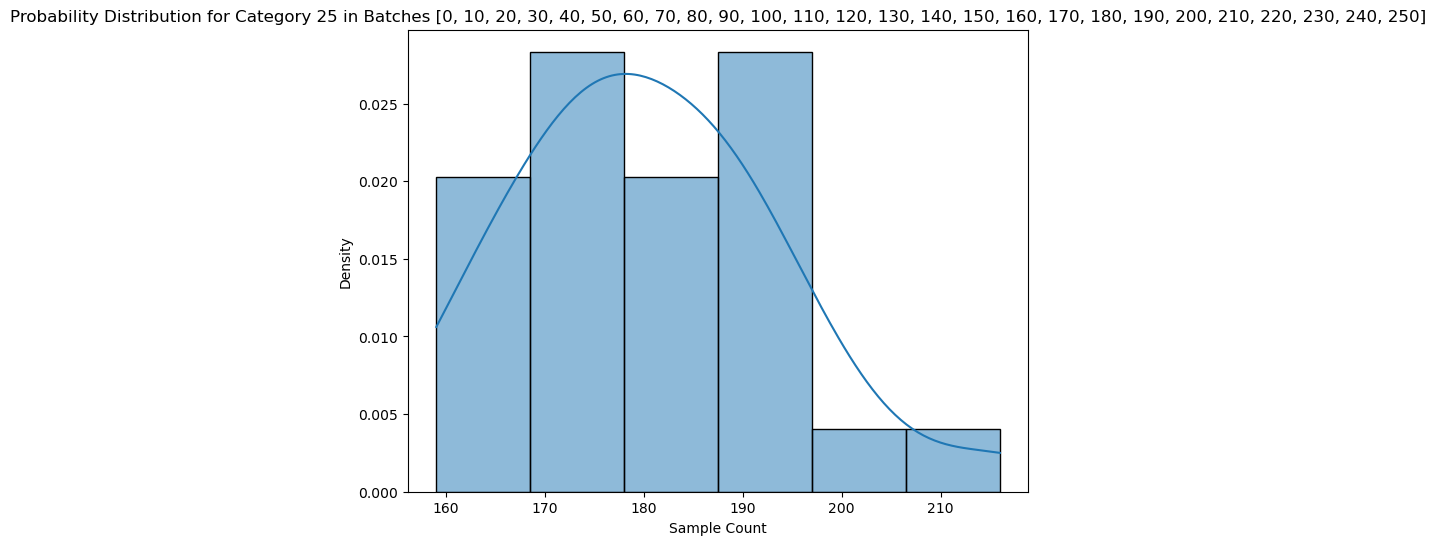

In [40]:
category_index = 25  # Eating Activity
batch_indices = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]  # batch indices to visualize -> Batch numbe 0,10,20
plot_probability_distribution(counts_b, category_index, batch_indices)